In [29]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #to normalize data
from os.path import exists

In [30]:
#see https://github.com/archd3sai/Predictive-Maintenance-of-Aircraft-Engine/blob/master/RUL%20Prediction%20Regression/LSTM%20RUL%20Prediction.ipynb
#dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    
df_train = pd.read_csv('train_FD004.txt',delim_whitespace=True,names=input_file_column_names)
    
df_test = pd.read_csv('test_FD004.txt',delim_whitespace=True,names=input_file_column_names)

df_train = df_train.drop(cols_to_drop, axis = 1)
df_test = df_test.drop(cols_to_drop, axis = 1)

In [18]:
print("Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time\n")
print("Classification: Predicting the failure of machine in upcoming n days\n")
print("The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles\n")
print("RUL - remaining useful life\n\n")
print(df_train.head(1))
print(df_test.head(1))

Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time

Classification: Predicting the failure of machine in upcoming n days

The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles

RUL - remaining useful life


   UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1  42.0049    0.84          549.68         1343.43   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0         1112.93          137.36         2211.86         8311.32   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            41.69           129.78          2387.99           9.3335   

   SensorMeasure17  SensorMeasure20  SensorMeasure21  
0              330            10.62            6.367  
   UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1  20.0072     0.7  

In [19]:
print("Find the max cycle count for each unit\n"
     )
rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
print(rul.head(3))


df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)
print(df_train.head(3))


rul2 = pd.DataFrame(df_test.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul2.columns = ['UnitNumber', 'max']


df_test = df_test.merge(rul2, on=['UnitNumber'], how='left')
df_test['RUL'] = df_test['max'] - df_test['Cycle']
df_test.drop('max', axis=1, inplace=True)


Find the max cycle count for each unit

   UnitNumber  max
0           1  321
1           2  299
2           3  307
   UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1  42.0049  0.8400          549.68         1343.43   
1           1      2  20.0020  0.7002          606.07         1477.61   
2           1      3  42.0038  0.8409          548.95         1343.12   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0         1112.93          137.36         2211.86         8311.32   
1         1237.50          332.10         2323.66         8713.60   
2         1117.05          138.18         2211.92         8306.69   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            41.69           129.78          2387.99           9.3335   
1            43.94           312.59          2387.73           9.1913   
2            41.66           129.62          2387.97           9.4007   

   SensorMeasure17  S

In [20]:
print(rul2.head(11))
print(df_test.head(11))
#y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
#y_true["UnitNumber"] = y_true.index

#print(y_true)

    UnitNumber  max
0            1  230
1            2  153
2            3  141
3            4  208
4            5   51
5            6  146
6            7   54
7            8  248
8            9  284
9           10   23
10          11   82
    UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0            1      1  20.0072  0.7000          606.67         1481.04   
1            1      2  24.9984  0.6200          536.22         1256.17   
2            1      3  42.0000  0.8420          549.23         1340.13   
3            1      4  42.0035  0.8402          549.19         1339.70   
4            1      5  35.0079  0.8400          555.10         1353.04   
5            1      6  25.0010  0.6203          536.40         1255.38   
6            1      7  19.9996  0.7015          607.29         1473.03   
7            1      8  35.0015  0.8414          554.81         1361.07   
8            1      9  19.9980  0.7000          607.35         1481.89   
9            1     1

In [22]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

X_Columns = [column for column in df_train.columns if column !="RUL"]


X_ColumnsTest = [column for column in df_test.columns if column !="RUL"]

min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[X_Columns] = min_max_scaler.fit_transform(df_train[X_Columns])
df_test[X_ColumnsTest] = min_max_scaler.fit_transform(df_test[X_ColumnsTest])
sequence_length=50
mask_value = 0

X_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, X_Columns)) for unit in df_train['UnitNumber'].unique()))
print("X_train",X_train.shape)
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
print("y_train",y_train.shape)



X_train (49048, 50, 17)
y_train (49048,)


In [23]:
X_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, X_ColumnsTest, mask_value)) for unit in df_test['UnitNumber'].unique()))
print("X_test",X_test.shape)
y_test = np.concatenate(list(list(gen_target(df_test[df_test['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_test['UnitNumber'].unique()))
print("y_test",y_test.shape)

nb_features = X_train.shape[2]
nb_out = 1



model = Sequential()
model.add(LSTM(
         units=512,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(
          units=128,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

C:\Users\elpaem\AppData\Local\Temp\ipykernel_11452\3406807512.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\elpaem\AppData\Local\Temp\ipykernel_11452\3406807512.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\elpaem\AppData\Local\Temp\ipykernel_11452\3406807512.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\elpaem\AppData\Local\Temp\ipykernel_11452\3406807512.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_inde

X_test (248, 50, 17)
y_test (29416,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 512)           1085440   
                                                                 
 batch_normalization (BatchN  (None, 50, 512)          2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 50, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                   

In [24]:

print ("Train the model")
length=len(X_train)
path_to_file="D:\\RulNasa\\lstm_aircraft_model4.h5"

file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
    
history=model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

model.save_weights(path_to_file)


Train the model
Epoch 1/3
1380/1380 [==============================] - 420s 302ms/step - loss: 300.1940 - mse: 300.1940 - val_loss: 2418.2041 - val_mse: 2418.2041
Epoch 2/3
1380/1380 [==============================] - 404s 293ms/step - loss: 271.5678 - mse: 271.5678 - val_loss: 2654.1760 - val_mse: 2654.1760
Epoch 3/3
1380/1380 [==============================] - 405s 294ms/step - loss: 254.6937 - mse: 254.6937 - val_loss: 2739.3442 - val_mse: 2739.3442


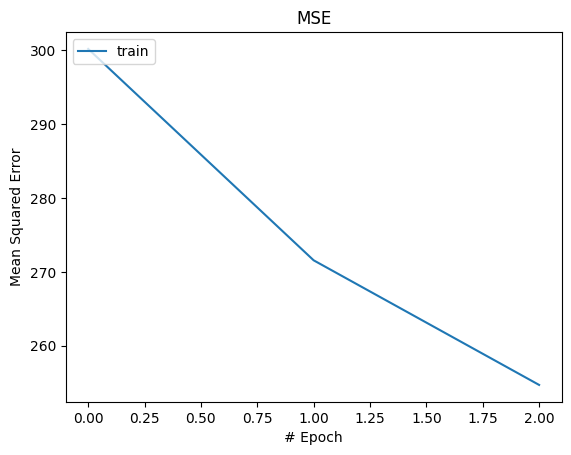

In [25]:
plt.plot(history.history['mse'])
#plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [26]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

246/246 [==============================] - 62s 252ms/step - loss: 461.2264 - mse: 461.2264
MSE: 461.22637939453125


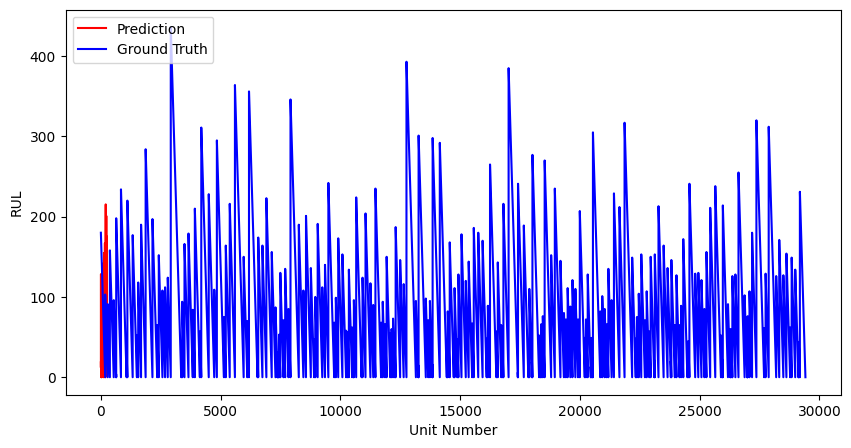

In [28]:
y_pred_test = model.predict(X_test, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()



In [ ]:
print("done!")